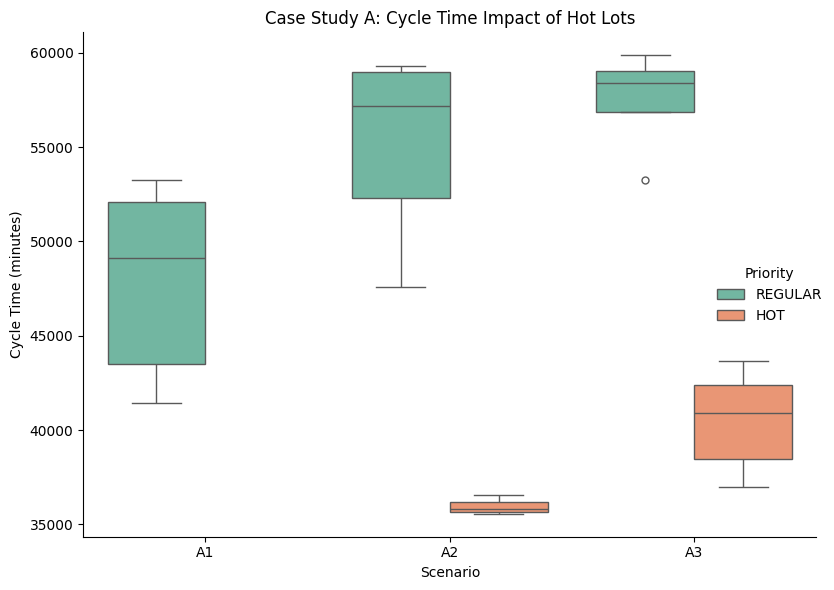

                   count          mean          std        min         25%  \
Scenario Priority                                                            
A1       REGULAR    10.0  47852.975800  4664.857974  41459.372  43518.1850   
A2       HOT         3.0  35975.044667   522.884627  35563.378  35680.8780   
         REGULAR     7.0  55217.135429  4954.082676  47605.088  52274.0580   
A3       HOT         6.0  40494.830667  2659.828867  36989.058  38460.3080   
         REGULAR     4.0  57491.653500  2910.871212  53268.710  56867.8955   

                         50%        75%        max  
Scenario Priority                                   
A1       REGULAR   49102.315  52074.814  53252.750  
A2       HOT       35798.378  36180.878  36563.378  
         REGULAR   57155.920  58957.509  59295.806  
A3       HOT       40881.619  42380.430  43683.450  
         REGULAR   58416.538  59040.296  59864.828  


In [2]:
import simpy
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load route data ---
file_path = "SMT_2020_Model_Data_-_LVHM.xlsx"
route_df = pd.read_excel(file_path, sheet_name='Route_Product_1')
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN', 'PROCESSING UNIT']].dropna()
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')

# --- Simulation constants ---
NUM_LOTS = 10
INTER_ARRIVAL_TIME = 20
SETUP_TIME = 5
PM_INTERVAL = 500
PM_DURATION = 30
MTBF = 800
MTTR = 60
SIM_TIME = 100000

BATCH_SIZE = 6
MIN_BATCH = 5
batch_tools = ['Diffusion_FE_125']

def run_case_study(hot_lot_ratio=0.2, scenario_label="A2", seed=42):
    global env, lot_times, tool_resources, tool_available, last_operation, batch_queues

    lot_times = {}

    env = simpy.Environment()
    tool_resources = {}
    tool_available = {}
    last_operation = {}
    batch_queues = {}

    for tool in steps['TOOLGROUP'].unique():
        tool_resources[tool] = simpy.PriorityResource(env, capacity=1)
        tool_available[tool] = True
        last_operation[tool] = None
        if tool in batch_tools:
            batch_queues[tool] = []

    def tool_downtime_behavior(env, tool_name):
        while True:
            yield env.timeout(PM_INTERVAL)
            tool_available[tool_name] = False
            yield env.timeout(PM_DURATION)
            tool_available[tool_name] = True
            yield env.timeout(random.expovariate(1.0 / MTBF))
            tool_available[tool_name] = False
            yield env.timeout(random.expovariate(1.0 / MTTR))
            tool_available[tool_name] = True

    for tool in tool_resources:
        env.process(tool_downtime_behavior(env, tool))

    def process_lot_through_route(env, steps, lot_id, priority_label, priority_level):
        lot_times[lot_id] = {'start': env.now, 'end': None, 'priority': priority_label}

        for _, row in steps.iterrows():
            tool_name = row['TOOLGROUP']
            proc_time = row['MEAN']
            step_id = row['STEP']
            while not tool_available[tool_name]:
                yield env.timeout(5)

            if tool_name in batch_tools:
                queue = batch_queues[tool_name]
                batch_event = env.event()
                lot_info = (lot_id, priority_label, priority_level, batch_event, step_id)
                queue.append(lot_info)
                if len(queue) >= MIN_BATCH:
                    batch = queue[:BATCH_SIZE]
                    batch_queues[tool_name] = queue[BATCH_SIZE:]
                    with tool_resources[tool_name].request(priority=0) as request:
                        yield request
                        if last_operation[tool_name] != step_id:
                            yield env.timeout(SETUP_TIME)
                            last_operation[tool_name] = step_id
                        yield env.timeout(proc_time)
                        for (bid, blabel, _, bevent, _) in batch:
                            if not bevent.triggered:
                                bevent.succeed()
                yield batch_event
            else:
                with tool_resources[tool_name].request(priority=priority_level) as request:
                    yield request
                    if last_operation[tool_name] != step_id:
                        yield env.timeout(SETUP_TIME)
                        last_operation[tool_name] = step_id
                    yield env.timeout(proc_time)

        lot_times[lot_id]['end'] = env.now

    def lot_generator(env):
        for i in range(NUM_LOTS):
            lot_id = f"{scenario_label}_Lot-{i+1:03d}"
            is_hot = random.random() < hot_lot_ratio
            priority_label = "HOT" if is_hot else "REGULAR"
            priority_level = 0 if is_hot else 1
            env.process(process_lot_through_route(env, steps, lot_id, priority_label, priority_level))
            yield env.timeout(INTER_ARRIVAL_TIME)

    random.seed(seed)
    env.process(lot_generator(env))
    env.run(until=SIM_TIME)

    rows = []
    for lot_id, times in lot_times.items():
        if times['end'] is not None:
            rows.append({
                "Lot": lot_id,
                "Scenario": scenario_label,
                "Priority": times['priority'],
                "Start": times['start'],
                "End": times['end'],
                "CycleTime": times['end'] - times['start']
            })
    return pd.DataFrame(rows)

# --- Run Case Study A scenarios ---
df_a1 = run_case_study(hot_lot_ratio=0.0, scenario_label="A1")
df_a2 = run_case_study(hot_lot_ratio=0.2, scenario_label="A2")
df_a3 = run_case_study(hot_lot_ratio=0.5, scenario_label="A3")

df_caseA = pd.concat([df_a1, df_a2, df_a3])

# --- Plot results ---
sns.catplot(
    data=df_caseA,
    x="Scenario", y="CycleTime", hue="Priority",
    kind="box", palette="Set2", height=6, aspect=1.2
)
plt.title("Case Study A: Cycle Time Impact of Hot Lots")
plt.ylabel("Cycle Time (minutes)")
plt.xlabel("Scenario")
plt.tight_layout()
plt.show()



# --- Summary Stats ---
print(df_caseA.groupby(["Scenario", "Priority"])["CycleTime"].describe())
